# 1 - OPES expanded
Use OPES_EXPANDED to sample expanded (or generalized) ensembles.
</br>
The system is alanine dipeptide in vacuum (ala2).

In [1]:
root_path = '/import/a12/users/minvernizzi/PLUMED-masterclass/masterclass-22-03/'

import numpy as np
import plumed

import sys
sys.path.append(root_path + 'scripts')
from calcFES import calcFES, calcDeltaF, calcESS

In [2]:
#reuse same plumed kernel, to avoid multiple warnings
PLUMED_KERNEL=plumed.Plumed()
from functools import partial
plumed.read_as_pandas = partial(plumed.read_as_pandas, kernel=PLUMED_KERNEL)

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/mi/minvernizzi/miniconda3/envs/plumed-masterclass-2022/lib/libplumedKernel.so" +++


In [3]:
import matplotlib.pyplot as plt

try:
# https://github.com/luigibonati/fessa-color-palette/blob/master/fessa.py
    import fessa
    plt.set_cmap('fessa')
except:
    pass # no big deal

<Figure size 432x288 with 0 Axes>

In [4]:
KB = 0.0083144621
T0 = 300
BETA0 = 1/(KB*T0)
KBT = KB*T0

## Multicanonical simulation

In [5]:
folder = root_path + '1-opes_expanded/multithermal/'

colvar = plumed.read_as_pandas(folder+'COLVAR')
time = colvar['time'].to_numpy()/1000
deltaFs = plumed.read_as_pandas(folder+'DELTAFS')

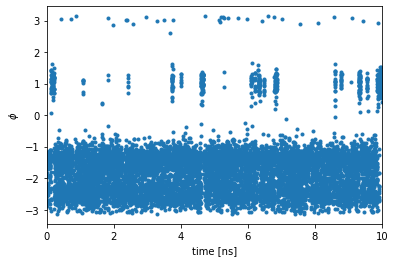

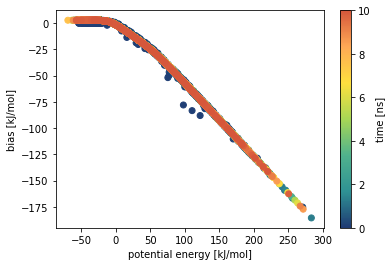

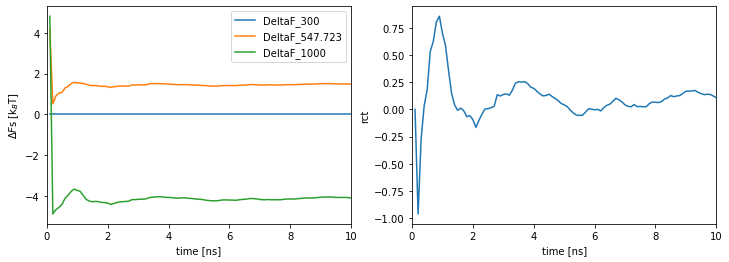

In [6]:
#plot phi
plt.plot(time, colvar['phi'], '.')
plt.ylabel('$\phi$')
plt.xlabel('time [ns]')
plt.xlim(time[0], time[-1])
plt.show()

#plot bias
plt.scatter(colvar['ene'], colvar['opes.bias'], c=time)
plt.ylabel('bias [kJ/mol]')
plt.xlabel('potential energy [kJ/mol]')
plt.colorbar(label='time [ns]')
plt.show()

#plot all deltaFs
fig, axs = plt.subplots(1, 2)
fig.set_size_inches((12, 4))

for col in deltaFs:
    if col != 'time' and col != 'rct':
        axs[0].plot(deltaFs['time']/1000, deltaFs[col]/KBT, label=col)
axs[0].set_ylabel('$\Delta F$s [k$_B$T]')
axs[0].legend()
#plot rct
axs[1].plot(deltaFs['time']/1000, deltaFs['rct'])
plt.ylabel('rct')
plt.setp(axs, xlabel='time [ns]', xlim=(time[0], time[-1]))
plt.show()

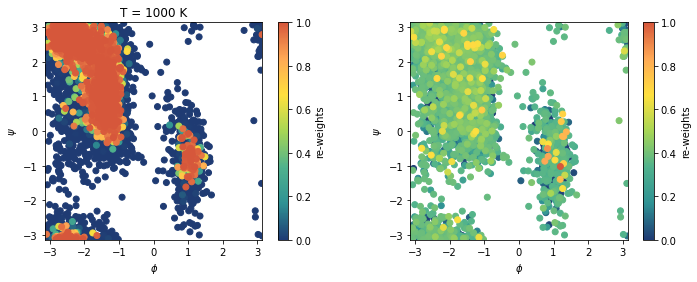

In [7]:
#plot phi-psi with weights for reweighting
def plot_phi_psi_weights(ax, logweights, colvar=colvar, sort=True):
    if sort:
        indexes = np.argsort(logweights)
    else:
        indexes = np.arange(len(logweights))
    sc = ax.scatter(colvar['phi'][indexes], colvar['psi'][indexes], c=np.exp(logweights[indexes]-max(logweights)))
    ax.set_aspect('equal')
    ax.set_ylabel('$\psi$')
    ax.set_xlabel('$\phi$')
    ax.set_ylim(-np.pi,np.pi)
    ax.set_xlim(-np.pi,np.pi)
    plt.colorbar(sc, ax=ax, label='re-weights')
    
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches((12, 4))
ax1.set_title('T = 300 K')
logweights = colvar['opes.bias']/KBT
plot_phi_psi_weights(ax1, logweights)

temp2 = 1000 #150
ax1.set_title(f'T = {temp2} K')
logweights = (colvar['opes.bias']+(1-T0/temp2)*colvar['ene'])/KBT
plot_phi_psi_weights(ax2, logweights)
plt.show()

In [8]:
%%time
#now calculate the actual free energy surface (FES)
nbins = 75
grid = np.linspace(-np.pi, np.pi, nbins)
X,Y = np.meshgrid(grid, grid)

transient = 0
bandwidth = (0.15, 0.15)
cvs = (colvar['phi'][transient:], colvar['psi'][transient:])

logweights = colvar['opes.bias'][transient:]/KBT
fes = calcFES((X,Y), bandwidth, cvs, logweights, periodic=True)
deltaF = calcDeltaF(fes, X<0) #basinA is x<0, basinB is x>0
print('half way...', end='\r')

temp2 = 1000
logweights = (colvar['opes.bias'][transient:]+(1-T0/temp2)*colvar['ene'][transient:])/KBT
fes_temp2 = calcFES((X,Y), bandwidth, cvs, logweights, periodic=True)
deltaF_temp2 = calcDeltaF(fes_temp2, X<0) #basinA is x<0, basinB is x>0

CPU times: user 16.2 s, sys: 750 µs, total: 16.2 s
Wall time: 16.2 s


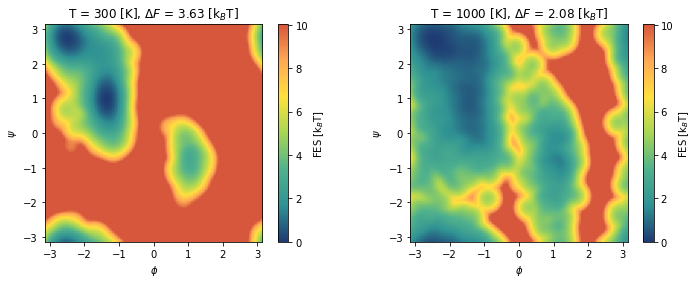

In [9]:
def plot_fes(ax, fes, max_fes=25/KBT):
    im = ax.imshow(fes, vmax=max_fes, origin='lower', extent=(-np.pi,np.pi,-np.pi,np.pi))
    ax.set_aspect('equal')
    ax.set_ylabel('$\psi$')
    ax.set_xlabel('$\phi$')
    ax.set_ylim(-np.pi,np.pi)
    ax.set_xlim(-np.pi,np.pi)
    plt.colorbar(im, ax=ax, label='FES [k$_B$T]')

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches((12, 4))
ax1.set_title(f'T = 300 [K], $\Delta F$ = {deltaF:.2f} [k$_B$T]')
plot_fes(ax1, fes)
ax2.set_title(f'T = {temp2} [K], $\Delta F$ = {deltaF_temp2:.2f} [k$_B$T]')
plot_fes(ax2, fes_temp2)
plt.show()

#### Effective sample size
We can quantify the efficiency of our multithermal simulation, by plotting the effective sample size (ESS or $n_{\text{eff}}$) as a function of temperature:
$$ n_{\text{eff}} = \frac{\left[\sum_k^n w_k\right]^2}{\sum_k^n w_k^2}$$
where $w_k$ are the reweighting weights. For nonuniform weights $0<n_{\text{eff}}<n$. The ratio between the effective sample size and the number of samples $n$ give us a first estimate of how good the sampling is.
However, this is only the loss in efficiency due to the importance sampling. Another efficiency loss comes from the fact that MD samples are correlated. This can be taken into account e.g. by a block average analysis. This will help you quantify if your simulation makes enough transitions between the metastable states.

OPES_EXPANDED calculates the $n_{\text{eff}}$ of the first few steps (OBSERVATION_STEPS=100 by default) in order to automatically choose the number of TEMP_STEPS to use for the expansion.

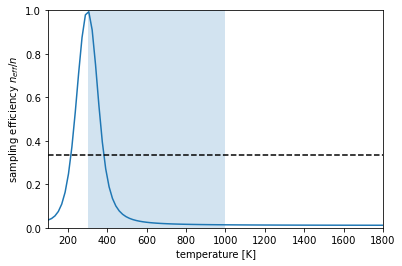

In [10]:
# calculate ESS of the initial unbiased samples
temp_min = 300
temp_max = 1000
temp_steps = 3
temps = np.linspace(100, 1800, 100)

start = len(np.where(colvar['opes.bias']==0)[0]) #only at the beginning the bias is perfectly zero
ESSs_start = np.array([calcESS(((1-T0/t)*colvar['ene'][:start])/KBT) for t in temps])

plt.plot(temps, ESSs_start/start)
plt.ylabel('sampling efficiency $n_{eff}/n$')
plt.xlabel('temperature [K]')
plt.xlim(temps[0], temps[-1])
plt.ylim(0, 1)
plt.axvspan(temp_min, temp_max, alpha=0.2)
plt.axhline(1/temp_steps, ls='--', c='k')
plt.show()

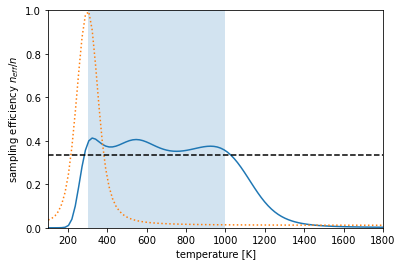

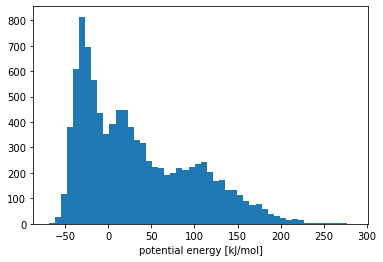

In [11]:
#plot effective sample size as a function of temperature
transient = start

ESSs = np.array([calcESS((colvar['opes.bias'][transient:]+(1-T0/t)*colvar['ene'][transient:])/KBT) for t in temps])

plt.plot(temps, ESSs/(len(colvar['time'][transient:])))
plt.plot(temps, ESSs_start/start, ls=':')
plt.ylabel('sampling efficiency $n_{eff}/n$')
plt.xlabel('temperature [K]')
plt.xlim(temps[0], temps[-1])
plt.ylim(0, 1)
plt.axvspan(temp_min, temp_max, alpha=0.2)
plt.axhline(1/temp_steps, ls='--', c='k')
plt.show()

#plot the sampled energy distribution
plt.hist(colvar['ene'][transient:], bins=50)
plt.xlabel('potential energy [kJ/mol]')
plt.show()

## Multiumbrella simulation

In [12]:
folder = root_path + '1-opes_expanded/multiumbrella/'

colvar = plumed.read_as_pandas(folder+'COLVAR')
time = colvar['time'].to_numpy()/1000
deltaFs = plumed.read_as_pandas(folder+'DELTAFS')

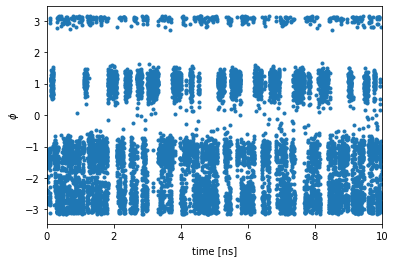

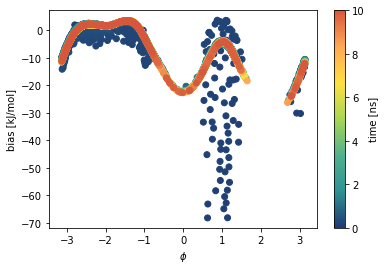

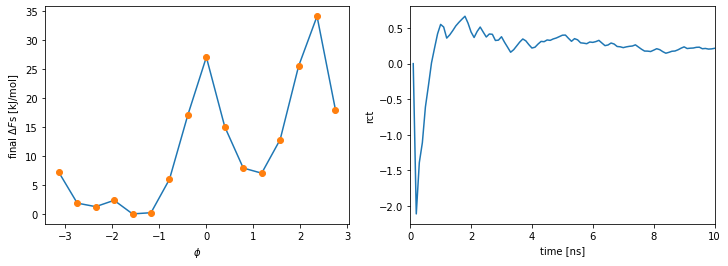

In [13]:
#plot phi
plt.plot(time, colvar['phi'], '.')
plt.ylabel('$\phi$')
plt.xlabel('time [ns]')
plt.xlim(time[0], time[-1])
plt.show()

#plot bias
plt.scatter(colvar['phi'], colvar['opes.bias'], c=time)
plt.ylabel('bias [kJ/mol]')
plt.xlabel('$\phi$')
plt.colorbar(label='time [ns]')
plt.show()

#plot deltaFs
fig, axs = plt.subplots(1, 2)
fig.set_size_inches((12, 4))
#extract umbrella positions from the DELTAFS file, DeltaF_value
phi_values = np.array([float(val[7:]) for val in deltaFs.columns[2:] if val != 'DeltaF_P0'])
final_deltaFs = deltaFs.iloc[-1][-len(phi_values):]
final_deltaFs -= min(final_deltaFs)
axs[0].plot(phi_values, final_deltaFs)
axs[0].plot(phi_values, final_deltaFs,'o')
axs[0].set_ylabel('final $\Delta F$s [kJ/mol]')
axs[0].set_xlabel('$\phi$')
#plot rct
axs[1].plot(deltaFs['time']/1000, deltaFs['rct'])
plt.ylabel('rct')
plt.setp(axs[1], xlabel='time [ns]', xlim=(time[0], time[-1]))
plt.show()

Bandwidth: 0.25, DeltaF estimate: 7.95346
Bandwidth: 0.20, DeltaF estimate: 8.26742
Bandwidth: 0.10, DeltaF estimate: 8.61222
Bandwidth: 0.05, DeltaF estimate: 8.65709


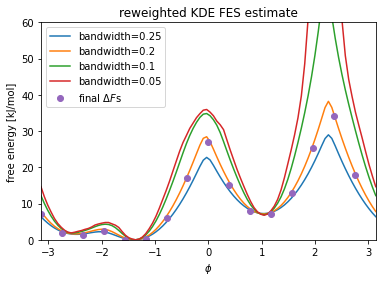

In [14]:
#reweighted FES estimate using kernel density estimate (KDE)
transient = 1000
nbins = 100
grid = np.linspace(-np.pi, np.pi, nbins)
logweights = colvar['opes.bias'][transient:]/KBT

plt.title('reweighted KDE FES estimate')
for bandwidth in [0.25, 0.2, 0.1, 0.05]:
    fes = KBT*calcFES(grid, bandwidth, colvar['phi'][transient:], logweights, periodic=True)
    print(f'Bandwidth: {bandwidth:.2f}, DeltaF estimate: {calcDeltaF(fes, grid<0, kbt=KBT):g}')
    plt.plot(grid, fes, label=f'bandwidth={bandwidth}')
plt.plot(phi_values, final_deltaFs, 'o', label='final $\Delta F$s')
plt.ylabel('free energy [kJ/mol]')
plt.xlabel('$\phi$')
plt.ylim(0, 60)
plt.xlim(-np.pi, np.pi)
plt.legend()
plt.show()

Now let's play around with the parameters of ECV_UMBRELLAS_LINE:
- what happens if we decrease the `SIGMA`?
- what is the effect of adding a `BARRIER` estimate?
- can we still estimate the DeltaF is we set `CV_MAX=2`?

We can also reproduce Masterclass 21.3, where they used 32 umbrellas with a `KAPPA=200`. The equivalent here would be to set `SIGMA=1/sqrt(200)` and `SPACING=2*pi/32*sqrt(200)`. But we'd better also specify a `BARRIER`...

## Combined multithermal and multiumbrella simulation

In [15]:
folder = root_path + '1-opes_expanded/combined-mtmu/'

try:
    colvar = plumed.read_as_pandas(folder+'COLVAR')
except: # are you using multiple walkers?
    # !cat {folder}?/COLVAR* > {folder}COLVAR
    !sort -gk1 {folder}?/COLVAR* > {folder}COLVAR
    colvar = plumed.read_as_pandas(folder+'COLVAR')
    !rm {folder}COLVAR
time = colvar['time'].to_numpy()/1000
deltaFs = plumed.read_as_pandas(folder+'DELTAFS')
state = plumed.read_as_pandas(folder+'STATE')

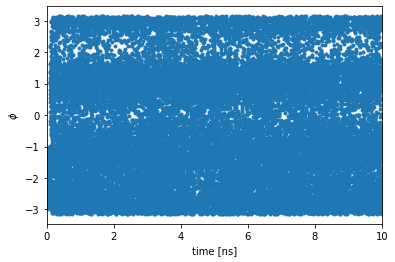

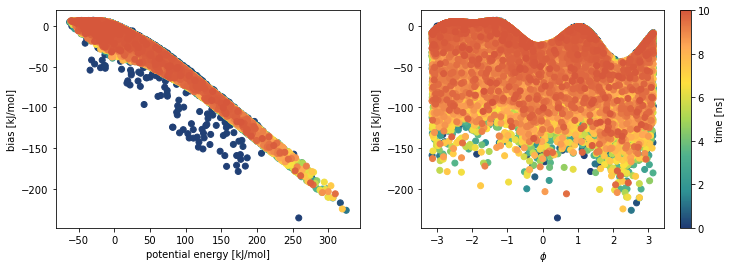

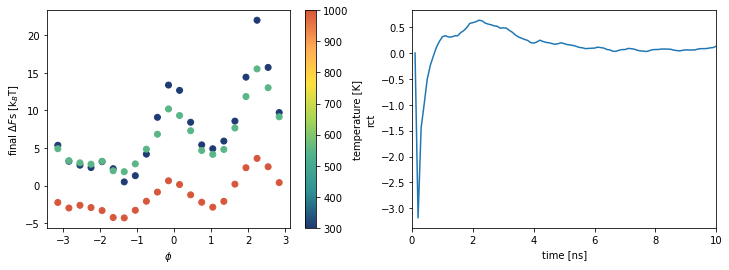

In [16]:
#plot phi
plt.plot(time, colvar['phi'], '.')
plt.ylabel('$\phi$')
plt.xlabel('time [ns]')
plt.xlim(time[0], time[-1])
plt.show()

#plot bias
fig, axs = plt.subplots(1, 2)
fig.set_size_inches((12, 4))
axs[0].scatter(colvar['ene'], colvar['opes.bias'], c=time)
axs[0].set_xlabel('potential energy [kJ/mol]')
sc = axs[1].scatter(colvar['phi'], colvar['opes.bias'], c=time)
axs[1].set_xlabel('$\phi$')
plt.setp(axs, ylabel='bias [kJ/mol]')
plt.colorbar(sc, ax=axs[1], label='time [ns]')
plt.show()

#plot final deltaFs
fig, axs = plt.subplots(1, 2)
fig.set_size_inches((12, 4))
num_deltaFs = len(deltaFs.iloc[-1][2:])
sc = axs[0].scatter(state['ecv_umb.phi'].iloc[:num_deltaFs], state['DeltaF'].iloc[:num_deltaFs]/KBT, c=state['ecv_mt.ene'].iloc[:num_deltaFs])
axs[0].set_ylabel('final $\Delta F$s [k$_B$T]')
axs[0].set_xlabel('$\phi$')
plt.colorbar(sc, ax=axs[0], label='temperature [K]')
#plot rct
axs[1].plot(deltaFs['time']/1000, deltaFs['rct'])
plt.ylabel('rct')
plt.setp(axs[1], xlabel='time [ns]', xlim=(time[0], time[-1]))
plt.show()

T = 300.0, DeltaF estimate: 3.6386 [kBT]
T = 547.7, DeltaF estimate: 2.79974 [kBT]
T =1000.0, DeltaF estimate: 2.20324 [kBT]


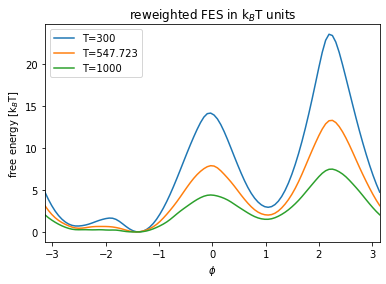

T = 300.0, DeltaF estimate: 9.07591 [kJ/mol]
T = 547.7, DeltaF estimate: 12.7501 [kJ/mol]
T =1000.0, DeltaF estimate: 18.3188 [kJ/mol]


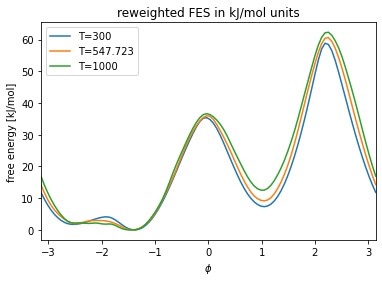

In [17]:
#1D FES
transient = 1000
grid = np.linspace(-np.pi, np.pi, 100)
bandwidth = 0.1
temps = np.unique(state['ecv_mt.ene'].iloc[:num_deltaFs])

plt.title('reweighted FES in k$_B$T units')
for t in temps:
    logweights = (colvar['opes.bias'][transient:]+(1-T0/t)*colvar['ene'][transient:])/KBT
    fes = calcFES(grid, bandwidth, colvar['phi'][transient:], logweights, periodic=True)
    print(f'T ={t:6.1f}, DeltaF estimate: {calcDeltaF(fes, grid<0):g} [kBT]')
    plt.plot(grid, fes, label=f'T={t:g}')
plt.ylabel('free energy [k$_B$T]')
plt.xlabel('$\phi$')
plt.xlim(-np.pi, np.pi)
plt.legend()
plt.show()

plt.title('reweighted FES in kJ/mol units')
for t in temps:
    kbt = KBT*t/T0
    logweights = (colvar['opes.bias'][transient:]+(1-T0/t)*colvar['ene'][transient:])/KBT
    fes = kbt*calcFES(grid, bandwidth, colvar['phi'][transient:], logweights, periodic=True)
    print(f'T ={t:6.1f}, DeltaF estimate: {calcDeltaF(fes, grid<0, kbt=kbt):g} [kJ/mol]')
    plt.plot(grid, fes, label=f'T={t:g}')
plt.ylabel('free energy [kJ/mol]')
plt.xlabel('$\phi$')
plt.xlim(-np.pi, np.pi)
plt.legend()
plt.show()

In [ ]:
%%time
#now calculate the 2D free energy surface (FES)
nbins = 75
grid = np.linspace(-np.pi, np.pi, nbins)
X,Y = np.meshgrid(grid, grid)

transient = 0
bandwidth = (0.15, 0.15)
cvs = (colvar['phi'][transient:], colvar['psi'][transient:])

logweights = colvar['opes.bias'][transient:]/KBT
fes = calcFES((X,Y), bandwidth, cvs, logweights, periodic=True)
deltaF = calcDeltaF(fes, X<0)
print('half way...', end='\r')

temp2 = 1000
logweights = (colvar['opes.bias'][transient:]+(1-T0/temp2)*colvar['ene'][transient:])/KBT
fes_temp2 = calcFES((X,Y), bandwidth, cvs, logweights, periodic=True)
deltaF_temp2 = calcDeltaF(fes_temp2, X<0)

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches((12, 4))
ax1.set_title(f'T = 300 [K], $\Delta F$ = {deltaF:.2f} [k$_B$T]')
plot_fes(ax1, fes)
ax2.set_title(f'T = {temp2} K, $\Delta F$ = {deltaF_temp2:.2f} [k$_B$T]')
plot_fes(ax2, fes_temp2)
plt.show()
print(f'DeltaF estimate at 300K: {KBT*calcDeltaF(fes, X<0):g} [kJ/mol]')